# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn

plt.style.use("seaborn-v0_8-paper")
import numpy as np
import torch
from sklearn import datasets, decomposition

In [3]:
from polcanet import LinearDecoder, PolcaNet
from polcanet.example_aencoders import (
    MinMaxScalerTorch,
    StandardScalerTorch,
    autoencoder_factory,
)

In [4]:
import polcanet.polcanet_reports as report

In [5]:
np.random.seed(5)

In [6]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

### Load dataset

In [7]:
digits = datasets.load_digits()
X = digits.data / 255
y = digits.target
X.shape, X[0].shape

((1797, 64), (64,))

### Fit standard sklearn PCA

In [8]:
pca = decomposition.PCA(n_components=8)
pca.fit(X)
Xpca = pca.transform(X)
pca.explained_variance_ratio_

array([0.14890594, 0.13618771, 0.11794594, 0.08409979, 0.05782415,
       0.0491691 , 0.04315987, 0.03661373])

### Fit POLCANet

In [35]:
ae_input = X
act_fn = torch.nn.Mish
input_dim = (ae_input.shape[1],)
latent_dim = 8  # Hey! ... let the kids alone!

encoder = autoencoder_factory(
    input_dim=input_dim,
    latent_dim=latent_dim,
    hidden_dim=1024,
    num_layers=10,
    autoencoder_type="dense",
    act_fn=act_fn,
)

decoder = LinearDecoder(latent_dim=latent_dim, input_dim=input_dim, hidden_dim=1024, num_layers=2, act_fn=None)


model = PolcaNet(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    alpha=0.01,  # ortgogonality loss
    beta=0.1,  # variance sorting loss
    gamma=0.1,  # variance reduction loss
    device="cuda",
    # scaler = MinMaxScalerTorch(),
)
model

PolcaNet(
  (encoder): DenseAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=64, out_features=1024, bias=True)
      (1): Mish()
      (2): ResNet(
        (module): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (4): Mish()
      (5): ResNet(
        (module): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (6): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (7): Mish()
      (8): ResNet(
        (module): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (9): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (10): Mish()
      (11): ResNet(
        (module): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (12): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (13): Mish()
      (14): ResNet(
        (module): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (15

In [36]:
model.to("cuda")
model.train_model(data=X, batch_size=512, num_epochs=10000, report_freq=100, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
Total Loss: 0.01225
Reconstruction Loss: 0.0003295
Orthogonality Loss: 0.9999
Center of Mass Loss: 0.008755
Variance Distribution Loss: 0.01044


In [37]:
model.train_model(data=X, batch_size=512, num_epochs=10000, report_freq=100, lr=1e-4)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
Total Loss: 0.002365
Reconstruction Loss: 0.0002225
Orthogonality Loss: 0.03796
Center of Mass Loss: 0.009761
Variance Distribution Loss: 0.007867


In [38]:
model.train_model(data=X, batch_size=512, num_epochs=10000, report_freq=100, lr=1e-5)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
Total Loss: 0.002333
Reconstruction Loss: 0.0002052
Orthogonality Loss: 0.03663
Center of Mass Loss: 0.009973
Variance Distribution Loss: 0.007641


## Evaluate results

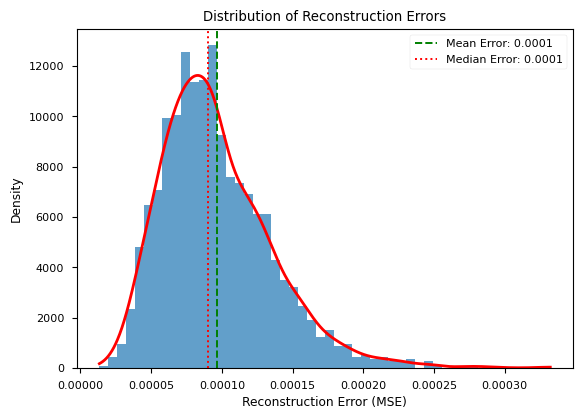

Mean Reconstruction Error: 0.0001
Median Reconstruction Error: 0.0001
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0003


In [13]:
report.analyze_reconstruction_error(model, X)

In [14]:
latents, reconstructed = model.predict(X)

In [15]:
report.analyze_latent_space(model, latents=latents)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 8
Total variance in latent space: 343.0169

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.5743
First 5 components              1
Components for 95% variance     3
Variance Concentration Metric   0.938

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.1221
Median absolute off-diagonal          0.1272
Max absolute off-diagonal             0.1638
Proportion of |Orthogonality| > 0.1   0.7857
Orthogonality Success Metric          0.8779

Orthogonality Interpretation:
Good orthogonality, but there might be roo

/data/deploy/polcanet/polcanet/polcanet_reports.py:318: RuntimeWarning: Mean of empty slice
  f"{np.nanmean(np.abs(corr[i, i + 1:])):.4f}"])



    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0035
    - Max cosine similarity: 0.0211
    - Min cosine similarity: -0.0450
    


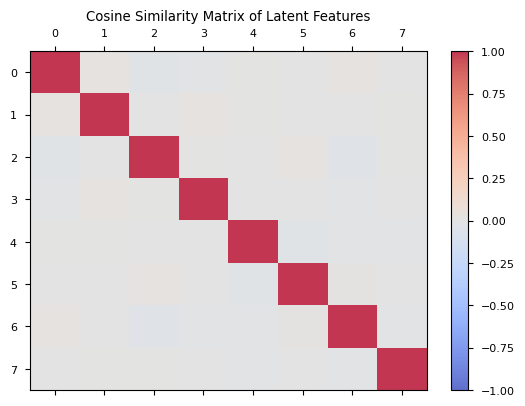

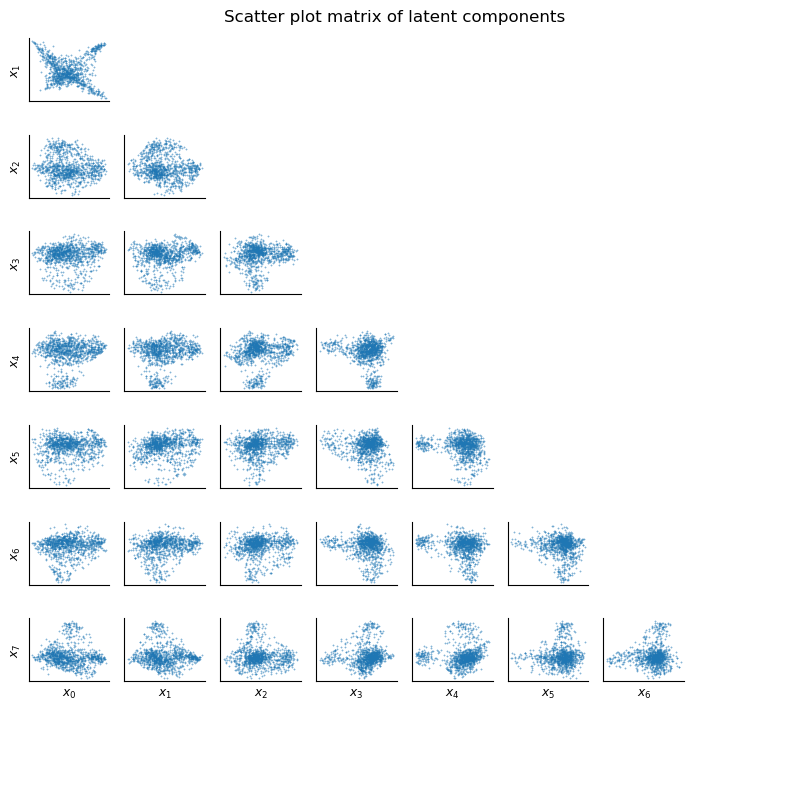

In [16]:
report.orthogonality_test_analysis(model, X)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.4971
    - Variance fit to exponential distribution (sum of squared differences):
     0.0189
    


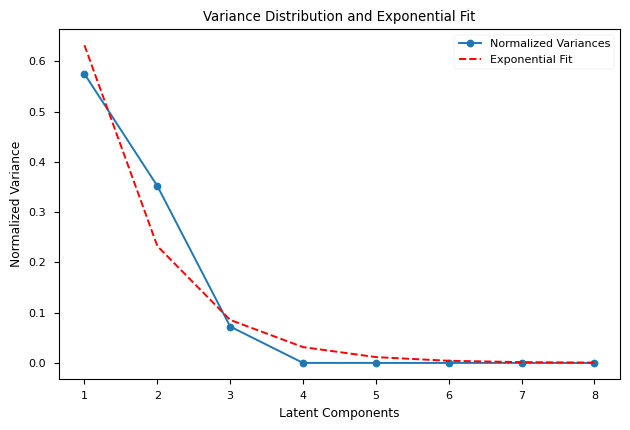

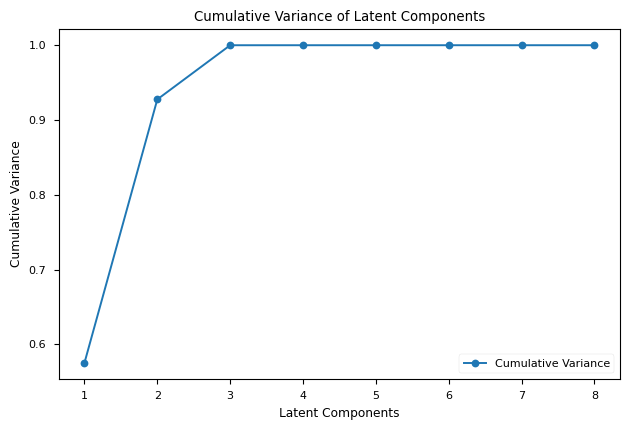

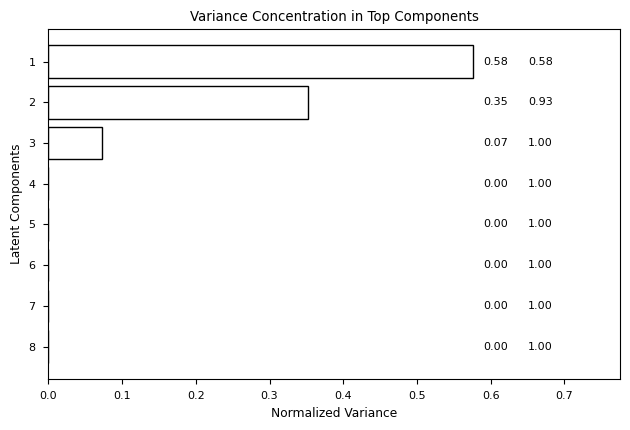

In [17]:
report.variance_test_analysis(model, X)


    Linearity Tests Analysis

    This report analyzes the linearity properties of the autoencoder. We used a sample size of
    1000 randomly selected data points for the analysis.

    The linearity properties of the features are assessed through two tests: additive property
    and homogeneity property. The results are summarized below:

    1. Additive Property:
    ---------------------
    The additive property is tested to verify if:

    f(z_x + z_y) = f(z_x) + f(z_y)

    The differences between the left-hand side and the right-hand side of the equation are
    summarized below:

    - Mean difference: 0.0209
    - Max difference: 0.0769
    - Min difference: 0.0000

    2. Homogeneity Property (Scalar alpha):
    ---------------------------------------
    The homogeneity property is tested to verify if:

    f(a.z_x) = a.f(z_x_)

    The differences between the left-hand side and the right-hand side of the equation are
    summarized below:

    - Mean difference: 0.0095
  

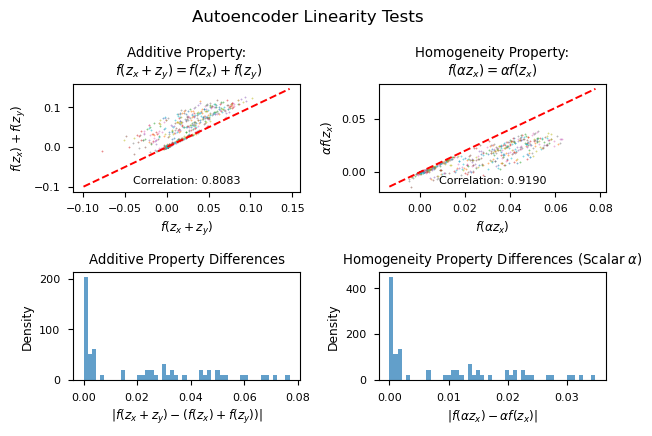

In [18]:
report.linearity_tests_analysis(model, X)

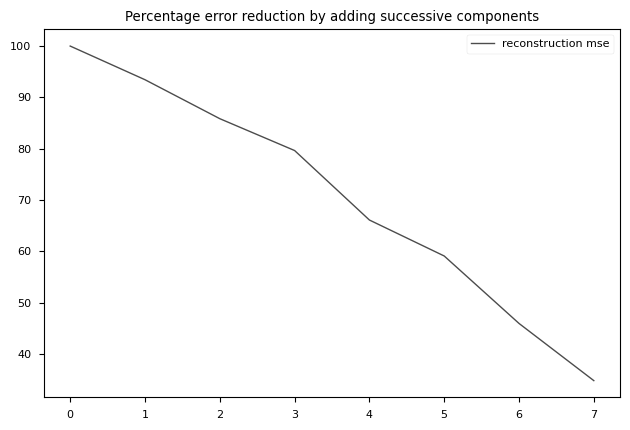

In [19]:
report.plot_cumsum_variance(model, X)

## Polca Net vs. PCA

In [20]:
def plot2d_analysis(X, y, title, legend=True):
    fig = plt.figure(1, figsize=(5, 5))
    ax = fig.add_subplot(111)

    for label in range(10):
        ax.scatter(X[y == label, 0], X[y == label, 1], label=label)
        ax.set_xlabel("component: 0")
        ax.set_ylabel("component 1")
    if legend:
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()
    return fig, ax

In [21]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    _, _ = plot2d_analysis(Xpca, y, title="PCA transform", legend=True)
with o2:
    _, _ = plot2d_analysis(latents, y, title="POLCA-Net latent")
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

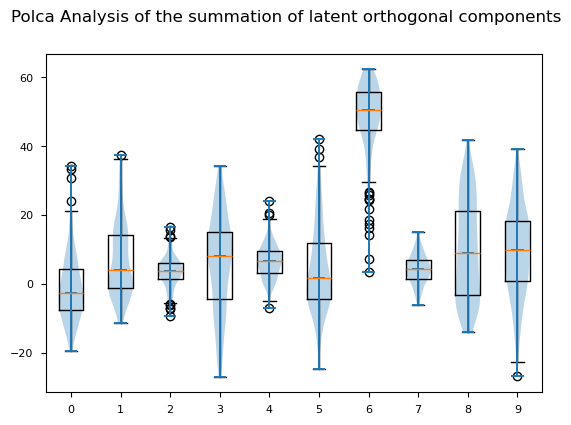

In [23]:
latents, reconstructed = model.predict(X)
vectors = []
labels = [str(i) for i in range(10)]
for c, label in enumerate(labels):
    vectors.append(np.sum(latents[y == c, :], axis=1))


plt.boxplot(vectors, tick_labels=labels)
plt.violinplot(vectors, showmeans=False, showmedians=True)
plt.suptitle("Polca Analysis of the summation of latent orthogonal components")
plt.show()

In [24]:
import seaborn as sns

o1 = widgets.Output()
o2 = widgets.Output()


with o1:
    scores = model.score(X)
    sns.displot(scores, kde=True)
    plt.title("Last component with clean data")
    plt.show()

with o2:
    scores = model.score(X * (np.random.random(size=X.shape) - 0.5) * 1)
    sns.displot(scores, kde=True)
    plt.title("Last componet with uniform noise in data")
    plt.show()


layout = widgets.Layout(grid_template_columns="repeat(2, 500px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 500px)'))

In [25]:
model.std_metrics

array([14.034973  , 11.04208   ,  4.9091773 ,  0.06406985,  0.04168806,
        0.03887746,  0.0299317 ,  0.02548395], dtype=float32)

In [26]:
model.mean_metrics

array([ 3.9937358 ,  4.152495  ,  1.7065486 , -0.02541083, -0.01726544,
       -0.01335759, -0.01155484,  0.00692654], dtype=float32)

## Test Classification with two components on PCA vs POLCA Net

In [27]:
import pandas as pd
from scipy.stats import ttest_rel
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import minmax_scale, scale
from sklearn.svm import SVC

In [28]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca.shape, X_test_pca.shape

((1257, 8), (540, 8))

In [30]:
# Transform the data using POLCA-Net
# X_train_polca = model.predict(X_train,np.array([1, 1, 0, 0]))[0][:,:2]
X_train_polca = model.predict(X_train)[0][:, :8]
# X_test_polca = model.predict(X_test, np.array([1, 1, 0, 0]))[0][:,:2]
X_test_polca = model.predict(X_test)[0][:, :8]
X_train_polca.shape, X_test_polca.shape

((1257, 8), (540, 8))

In [31]:
# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Linear SVM": SVC(kernel="linear", probability=True),
    "Ridge Classifier": RidgeClassifier(),
    "Perceptron": Perceptron(),
}

In [32]:
# Train and evaluate classifiers on both PCA and POLCA-Net transformed datasets
results = []

for name, clf in classifiers.items():
    # Train on PCA
    clf.fit(minmax_scale(X_train_pca), y_train)
    y_pred_pca = clf.predict(minmax_scale(X_test_pca))
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    report_pca = classification_report(y_test, y_pred_pca, output_dict=True)
    cm_pca = confusion_matrix(y_test, y_pred_pca)

    # Train on POLCA-Net
    clf.fit(minmax_scale(X_train_polca), y_train)
    y_pred_polca = clf.predict(minmax_scale(X_test_polca))
    accuracy_polca = accuracy_score(y_test, y_pred_polca)
    report_polca = classification_report(y_test, y_pred_polca, output_dict=True)
    cm_polca = confusion_matrix(y_test, y_pred_polca)

    # Append results
    results.append(
        {
            "Classifier": name,
            "Transformation": "PCA",
            "Accuracy": accuracy_pca,
            "Precision": report_pca["weighted avg"]["precision"],
            "Recall": report_pca["weighted avg"]["recall"],
            "F1-Score": report_pca["weighted avg"]["f1-score"],
            "Confusion Matrix": cm_pca,
        }
    )

    results.append(
        {
            "Classifier": name,
            "Transformation": "POLCA-Net",
            "Accuracy": accuracy_polca,
            "Precision": report_polca["weighted avg"]["precision"],
            "Recall": report_polca["weighted avg"]["recall"],
            "F1-Score": report_polca["weighted avg"]["f1-score"],
            "Confusion Matrix": cm_polca,
        }
    )

In [33]:
# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Display the main metrics table
main_metrics_df = results_df.drop(columns=["Confusion Matrix"])
main_metrics_df

,Classifier,Transformation,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,PCA,0.851852,0.857367,0.851852,0.852770
1,Logistic Regression,POLCA-Net,0.859259,0.865780,0.859259,0.860278
2,Gaussian Naive Bayes,PCA,0.861111,0.866776,0.861111,0.862104
3,Gaussian Naive Bayes,POLCA-Net,0.837037,0.854535,0.837037,0.842161
4,Linear SVM,PCA,0.905556,0.909331,0.905556,0.906228
5,Linear SVM,POLCA-Net,0.901852,0.905628,0.901852,0.902512
6,Ridge Classifier,PCA,0.812963,0.817767,0.812963,0.808361
7,Ridge Classifier,POLCA-Net,0.818519,0.824781,0.818519,0.809858
8,Perceptron,PCA,0.759259,0.860092,0.759259,0.733223
9,Perceptron,POLCA-Net,0.777778,0.819003,0.777778,0.769580


In [34]:
# Statistical test: Paired t-test for accuracies
pca_accuracies = results_df[results_df["Transformation"] == "PCA"]["F1-Score"]
polca_accuracies = results_df[results_df["Transformation"] == "POLCA-Net"]["F1-Score"]

t_stat, p_value = ttest_rel(pca_accuracies.values, polca_accuracies.values)

print(f"\nPaired t-test results: t-statistic = {t_stat}, p-value = {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the PCA and POLCA-Net transformations.")
else:
    print("There is no statistically significant difference between the PCA and POLCA-Net transformations.")


Paired t-test results: t-statistic = -0.4711153967737403, p-value = 0.6621030979878006
There is no statistically significant difference between the PCA and POLCA-Net transformations.


In [ ]:
# Plotting the results
plt.figure(figsize=(10, 4))

# Plot PCA
plt.subplot(1, 2, 1)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap="viridis", edgecolor="k", s=50)
plt.title("PCA: Iris Test Set")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

# Plot POLCA-Net
plt.subplot(1, 2, 2)
plt.scatter(X_test_polca[:, 0], X_test_polca[:, 1], c=y_test, cmap="viridis", edgecolor="k", s=50)
plt.title("POLCA-Net: Iris Test Set")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.show()

# Plot Confusion Matrices for each classifier
fig, axes = plt.subplots(len(classifiers), 2, figsize=(10, 20))

for i, (name, clf) in enumerate(classifiers.items()):
    # PCA Confusion Matrix
    cm_pca = results_df[(results_df["Classifier"] == name) & (results_df["Transformation"] == "PCA")]["Confusion Matrix"].values[0]
    axes[i, 0].imshow(cm_pca, interpolation="nearest", cmap=plt.cm.Blues)
    axes[i, 0].set_title(f"{name} Confusion Matrix - PCA")
    axes[i, 0].set_xlabel("Predicted label")
    axes[i, 0].set_ylabel("True label")

    # POLCA-Net Confusion Matrix
    cm_polca = results_df[(results_df["Classifier"] == name) & (results_df["Transformation"] == "POLCA-Net")]["Confusion Matrix"].values[0]
    axes[i, 1].imshow(cm_polca, interpolation="nearest", cmap=plt.cm.Blues)
    axes[i, 1].set_title(f"{name} Confusion Matrix - POLCA-Net")
    axes[i, 1].set_xlabel("Predicted label")
    axes[i, 1].set_ylabel("True label")

plt.tight_layout()
plt.show()